<a href="https://colab.research.google.com/github/Pierre-Alexandre01/Bitcoin-Forecast/blob/main/Portfolio_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#!/usr/bin/env python3
"""
Portfolio Risk Lab — speculative + gold friendly
------------------------------------------------
Features:
- Fetch historical prices for your tickers (Yahoo Finance via yfinance)
- Compute annualized return, volatility, Sharpe, max drawdown
- VaR/CVaR at 95% (1-day and 21-day)
- Monte Carlo simulation (by sampling from historical mean/cov)
- Simple stress tests (equity crash, gold drop, crypto drawdown)
- Optional charts

Usage:
    1) pip install yfinance pandas numpy matplotlib
    2) Edit the CONFIG section below (tickers, weights, start date, etc.)
    3) Run: python portfolio_risk_lab.py

Notes:
- Tickers are Yahoo Finance symbols (e.g., TQQQ, UGL, ARKK, BTC-USD).
- Leveraged gold ETFs examples: UGL (2x long gold), DGP (2x), NUGT (miners 2x - different risk), etc.
- Swissquote may list products with different symbols; for analysis, use Yahoo-compatible tickers.
"""

'\nPortfolio Risk Lab — speculative + gold friendly\n------------------------------------------------\nFeatures:\n- Fetch historical prices for your tickers (Yahoo Finance via yfinance)\n- Compute annualized return, volatility, Sharpe, max drawdown\n- VaR/CVaR at 95% (1-day and 21-day)\n- Monte Carlo simulation (by sampling from historical mean/cov)\n- Simple stress tests (equity crash, gold drop, crypto drawdown)\n- Optional charts\n\nUsage:\n    1) pip install yfinance pandas numpy matplotlib\n    2) Edit the CONFIG section below (tickers, weights, start date, etc.)\n    3) Run: python portfolio_risk_lab.py\n\nNotes:\n- Tickers are Yahoo Finance symbols (e.g., TQQQ, UGL, ARKK, BTC-USD).\n- Leveraged gold ETFs examples: UGL (2x long gold), DGP (2x), NUGT (miners 2x - different risk), etc.\n- Swissquote may list products with different symbols; for analysis, use Yahoo-compatible tickers.\n'

In [42]:
import sys
import json
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from dataclasses import dataclass
from typing import List, Dict, Optional
from pathlib import Path
from sklearn.covariance import LedoitWolf
!pip install cvxpy osqp ecos
!pip install ecos
# (ECOS_BB comes with ecos; OSQP is great for QP)

import numpy as np
import pandas as pd

# Optional: charts
try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except Exception:
    HAS_MPL = False

def set_mpl_style():
    """
    Minimal, publication-like styling without specifying colors.
    """
    if not HAS_MPL:
        return
    plt.rcParams.update({
        "figure.figsize": (8,5),
        "axes.titleweight": "bold",
        "axes.titlesize": 14,
        "axes.labelsize": 11,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.5,
        "grid.alpha": 0.5,
        "axes.axisbelow": True,
        "legend.frameon": False,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "savefig.bbox": "tight",
    })

try:
    import yfinance as yf
except ImportError:
    print("yfinance not installed. Install with: pip install yfinance")
    sys.exit(1)

In [43]:
# -------------------------------
# CONFIG — EDIT ME
# -------------------------------
CONFIG = {
    "universe_preset": "broad_multi_asset",   # e.g. includes equities, ETFs, bonds, crypto
    "universe_file": None,                    # don’t load from CSV
    "max_assets": 60,                         # keep up to 60 tickers after filtering
    "min_history_days": 750,                  # require ~3 years of history
    "min_coverage": 0.90,                     # drop assets with too many missing values



    "start": "2010-01-01",
    "end": None,
    "risk_free_annual": 0.02,
    "mc_paths": 20000,
    "mc_days": 252,
    "make_charts": True,
    "show_plots": True,
    "save_folder": "outputs",

    # Benchmark
    "benchmark_ticker": "AOR",

    # Which crises to analyze (only those within your data range will be used)
    "crisis_windows": [
        {"name":"Global Financial Crisis", "start":"2007-10-01", "end":"2009-03-09"},
        {"name":"US Downgrade / Euro wobble", "start":"2011-07-22", "end":"2011-10-03"},
        {"name":"Taper Tantrum", "start":"2013-05-22", "end":"2013-06-24"},
        {"name":"China/Commodities", "start":"2015-05-21", "end":"2016-02-11"},
        {"name":"Q4 2018", "start":"2018-09-20", "end":"2018-12-24"},
        {"name":"COVID crash", "start":"2020-02-19", "end":"2020-03-23"},
        {"name":"2022 Bear", "start":"2022-01-03", "end":"2022-10-12"},
    ],
        # --- Optimizer options ---
    "run_optimizer": True,
    "optimizer": {
    "mode": "mean_variance",
    "risk_aversion": 8.0,
    "target_vol": None,
    "target_return": None,
    "te_max": None,            # drop TE, rely on group caps
    "long_only": True,
    "w_min": 0.0,
    "w_max": 0.1,             # tighter single-name cap
    "cardinality": None,
    "min_position": 0.1,
    "random_samples": 30000,
    "turnover_max": 0.30,      # max absolute weight change sum (per rebalance), e.g. 30%
    "tc_bps": 5,               # per-side trading cost in bps (used in objective penalty)
    "l2_ridge": 1e-4,          # mild ℓ2 regularization on weights (stabilizes solutions)
    "prev_weights_file": "outputs/optimized_weights.csv",  # used if present
    },

    "walk_forward": {
    "rebalance_freq": "M",       # "M" monthly, "Q" quarterly
    "lookback_days": 756,        # ~3y of data to estimate
    "start_buffer_days": 1000,   # wait until enough history before first trade
    "tc_bps": 5,                 # per-side cost
}

}

In [44]:
# -------------------------------
# Data classes
# -------------------------------
@dataclass
class PortfolioResult:
    ann_return: float
    ann_vol: float
    sharpe: float
    mdd: float
    var1d_95: float
    cvar1d_95: float
    var21d_95: float
    cvar21d_95: float
    summary_df: pd.DataFrame
    weights: pd.Series
    rets: pd.Series
    prices: pd.DataFrame
    cov_daily: pd.DataFrame
    mu_daily: pd.Series

In [45]:
# -------------------------------
# Helpers
# -------------------------------

TICKER_NAMES = {
    "AAPL": "Apple",
    "MSFT": "Microsoft",
    "AMZN": "Amazon",
    "GOOG": "Alphabet (Google)",
    "NVDA": "NVIDIA",
    "META": "Meta Platforms",
    "TSLA": "Tesla",
    "BRK-B": "Berkshire Hathaway",
    "JPM": "JPMorgan Chase",
    "V": "Visa",
    "XLI": "Industrial Select Sector ETF",
    "XLK": "Tech Select Sector ETF",
    "XLF": "Financial Select Sector ETF",
    "XLV": "Health Care Select Sector ETF",
    "XLY": "Consumer Discretionary ETF",
    "XLP": "Consumer Staples ETF",
    "SPY": "S&P 500 ETF",
    "QQQ": "Nasdaq 100 ETF",
    "IWM": "Russell 2000 ETF",
    "TLT": "20y+ Treasury Bond ETF",
    "GLD": "SPDR Gold Trust",
    "SLV": "iShares Silver Trust",
    "DBC": "Invesco Commodity Index ETF",
    "USO": "United States Oil Fund",
    "UNG": "United States Natural Gas Fund",
    "VNQ": "Real Estate ETF",
    "BTC-USD": "Bitcoin",
    "ETH-USD": "Ethereum",
    "SHY": "iShares 1–3 Year Treasury",
    "LQD": "iShares iBoxx $ Inv Grade Corporate",
    "HYG": "iShares iBoxx $ High Yield Corporate",
    "VGK": "Vanguard FTSE Europe ETF",
    "EFA": "iShares MSCI EAFE",
    "EEM": "iShares MSCI Emerging Markets",
    "EWJ": "iShares MSCI Japan",
    "EWZ": "iShares MSCI Brazil",
    "FXI": "iShares China Large-Cap",
    "IEF": "iShares 7–10 Year Treasury",
    "XLE": "Energy Select Sector ETF",
        # Leveraged / inverse equity
    "SQQQ": "ProShares UltraPro Short QQQ (−3x Nasdaq-100)",
    "SPXS": "Direxion Daily S&P 500 Bear 3X",
    "SPXL": "Direxion Daily S&P 500 Bull 3X",
    "UPRO": "ProShares UltraPro S&P 500 (3x)",
    "TQQQ": "ProShares UltraPro QQQ (3x)",
    "SOXL": "Direxion Daily Semiconductor Bull 3X",

    # Volatility ETPs
    "VIXY": "ProShares VIX Short-Term Futures ETF",
    "UVXY": "ProShares Ultra VIX Short-Term Futures (leveraged)",

    # Sectors / themes / commodities (levered)
    "SMH":  "VanEck Semiconductor ETF",
    "XBI":  "SPDR S&P Biotech ETF",
    "UGL":  "ProShares Ultra Gold (2x)",
    "DGP":  "DB Gold Double Long ETN (2x)",
    "NUGT": "Direxion Daily Gold Miners Bull (2x)",
    "BOIL": "ProShares Ultra Bloomberg Natural Gas (2x)",
    # … extend as you like
}
# 0) Put these near the helpers
CLASS_KEYS  = ["equities","bonds","commodities","crypto","inverse_equity","other"]
PRETTY_NAME = {
    "equities": "Equities",
    "bonds": "Bonds",
    "commodities": "Commodities",
    "crypto": "Crypto",
    "inverse_equity": "Equities (Hedge)",
    "other": "Other",
}


def _group_indices(cols):
    eq = {"SPY","QQQ","IWM","XLK","XLF","XLV","XLE","XLY","XLI","XLP",
          "AAPL","MSFT","NVDA","AMZN","GOOG","META","TSLA","JPM","V","BRK-B",
          "SMH"}                     # add sector/industry ETFs you use
    bonds = {"TLT","IEF","LQD","HYG","SHY"}
    cmd = {"GLD","SLV","DBC","USO","UNG","DGP","UGL"}  # add levered gold
    inverse_equity = {"SQQQ","SPXS","SPXU","SDOW"}     # inverse/leveraged equity

    eq_idx, bond_idx, cmd_idx, crypto_idx, inv_eq_idx = [],[],[],[],[]
    for i,t in enumerate(cols):
        if t in eq: eq_idx.append(i)
        elif t in bonds: bond_idx.append(i)
        elif t in cmd: cmd_idx.append(i)
        if "USD" in t: crypto_idx.append(i)
        if t in inverse_equity: inv_eq_idx.append(i)
    return dict(equities=eq_idx, bonds=bond_idx, commodities=cmd_idx,
                crypto=crypto_idx, inverse_equity=inv_eq_idx)

def asset_class_members(weights_s: pd.Series) -> dict:
    tickers = list(weights_s.index)
    groups = _group_indices(tickers)

    # index -> class
    idx_to_class = {}
    for cls, idxs in groups.items():
        for i in idxs:
            idx_to_class[i] = cls

    # build buckets for *all* classes you support
    buckets = {PRETTY_NAME[k]: [] for k in CLASS_KEYS}
    for i, t in enumerate(tickers):
        cls_key = idx_to_class.get(i, "other")
        pretty = PRETTY_NAME.get(cls_key, "Other")
        buckets[pretty].append((t, float(weights_s.loc[t])))

    for k in buckets:
        buckets[k].sort(key=lambda x: x[1], reverse=True)
    return buckets

def asset_class_breakdown(weights_s: pd.Series) -> pd.Series:
    tickers = list(weights_s.index)
    groups = _group_indices(tickers)

    # index -> class
    idx_to_class = {}
    for cls, idxs in groups.items():
        for i in idxs:
            idx_to_class[i] = cls

    # sum by class (include inverse_equity)
    sums = {k: 0.0 for k in CLASS_KEYS}
    for i, t in enumerate(tickers):
        cls_key = idx_to_class.get(i, "other")
        if cls_key not in sums:
            sums[cls_key] = 0.0
        sums[cls_key] += float(weights_s.loc[t])

    s = pd.Series(sums)
    s = s[s > 1e-10]  # drop zeros
    return s.rename(index=PRETTY_NAME).sort_values(ascending=False)

def plot_asset_class_pie(weights_s: pd.Series, out_path: Optional[str] = None, title: str = "Portfolio by Asset Class"):
    if not HAS_MPL:
        print("matplotlib not installed; skipping pie chart.")
        return
    breakdown = asset_class_breakdown(weights_s)

    # Optional: print a small table alongside the chart in the console
    print("\nAsset-class breakdown:")
    for k, v in breakdown.items():
        print(f"  {k:<12} {v:>6.2%}")

    # Pie chart
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.pie(
        breakdown.values,
        labels=[f"{lbl} ({w:.1%})" for lbl, w in zip(breakdown.index, breakdown.values)],
        autopct="%1.1f%%",
        startangle=90
    )
    ax.set_title(title, fontweight="bold")
    ax.axis("equal")  # make it a circle

    if out_path:
        plt.savefig(out_path, bbox_inches="tight")
        print(f"Saved asset-class pie → {out_path}")

    plt.show()

def ensure_weights(weights: List[float]) -> np.ndarray:
    w = np.array(weights, dtype=float)
    if not np.isclose(w.sum(), 1.0):
        raise ValueError(f"Weights must sum to 1.0 (got {w.sum():.6f}).")
    if (w < 0).any():
        raise ValueError("Weights cannot be negative in this script.")
    return w

def download_prices(tickers: List[str], start: str, end: Optional[str]) -> pd.DataFrame:
    data = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    data = data.dropna(how="all").ffill().dropna()
    missing = [t for t in tickers if t not in data.columns]
    if missing:
        raise ValueError(f"Missing tickers in downloaded data: {missing}")
    return data

def compute_portfolio_stats(prices: pd.DataFrame, weights: np.ndarray, rf_annual: float) -> PortfolioResult:
    rets = prices.pct_change().dropna()
    rets = _winsorize(rets, p=0.01)  # damp 1% tails

    # Mean: EWMA (126d) + long-run anchor blend
    ewma_mu = rets.ewm(span=126, min_periods=20).mean().iloc[-1]

    # simple long-run anchors (daily) by rough asset class
    anchors = []
    for col in rets.columns:
        u = col.upper()
        if any(k in u for k in ["SPY","QQQ","IWM","XL","AAPL","MSFT","NVDA","AMZN","GOOG","META","TSLA","JPM","V","BRK-B","EFA","EEM","EWJ","VGK","FXI","EWZ"]):
            anch_ann = 0.06
        elif any(k in u for k in ["TLT","IEF","LQD","HYG","SHY"]):
            anch_ann = 0.02
        elif any(k in u for k in ["GLD","SLV","DBC","USO","UNG"]):
            anch_ann = 0.03
        elif "USD" in u:  # BTC/ETH: set conservative or 0
            anch_ann = 0.00
        else:
            anch_ann = 0.03
        anchors.append((1 + anch_ann)**(1/252) - 1)
    anchor_mu = pd.Series(anchors, index=rets.columns)

    mu_daily = 0.5 * ewma_mu + 0.5 * anchor_mu

    # Covariance: Ledoit–Wolf on winsorized returns
    lw = LedoitWolf().fit(rets.values)
    cov_daily = pd.DataFrame(lw.covariance_, index=rets.columns, columns=rets.columns)
    port_rets = rets.dot(weights)

    # Annualization
    ann_return = (1 + port_rets).prod() ** (252 / len(port_rets)) - 1
    ann_vol = port_rets.std() * np.sqrt(252)
    rf_daily = (1 + rf_annual) ** (1 / 252) - 1
    sharpe = ((port_rets.mean() - rf_daily) * 252) / (ann_vol if ann_vol != 0 else np.nan)

    # Drawdown
    equity = (1 + port_rets).cumprod()
    peaks = equity.cummax()
    dd = equity / peaks - 1
    mdd = dd.min()

    # VaR / CVaR (historical)
    var1d_95 = -np.percentile(port_rets, 5)
    cvar1d_95 = -port_rets[port_rets <= np.percentile(port_rets, 5)].mean()

    # 21-day (approx month)
    roll21 = port_rets.rolling(21).sum().dropna()
    var21d_95 = -np.percentile(roll21, 5)
    cvar21d_95 = -roll21[roll21 <= np.percentile(roll21, 5)].mean()

    summary = pd.DataFrame({
        "Metric": [
            "Annualized return", "Annualized volatility", "Sharpe (rf=2%)",
            "Max drawdown", "1-day VaR 95%", "1-day CVaR 95%",
            "21-day VaR 95%", "21-day CVaR 95%"
        ],
        "Value": [
            ann_return, ann_vol, sharpe, mdd, var1d_95, cvar1d_95, var21d_95, cvar21d_95
        ]
    })

    return PortfolioResult(
        ann_return=ann_return, ann_vol=ann_vol, sharpe=sharpe, mdd=mdd,
        var1d_95=var1d_95, cvar1d_95=cvar1d_95, var21d_95=var21d_95, cvar21d_95=cvar21d_95,
        summary_df=summary, weights=pd.Series(weights, index=prices.columns, name="Weight"),
        rets=port_rets, prices=prices, cov_daily=cov_daily, mu_daily=mu_daily
    )

def _winsorize(df: pd.DataFrame, p: float = 0.01) -> pd.DataFrame:
    lo = df.quantile(p)
    hi = df.quantile(1 - p)
    return df.clip(lower=lo, upper=hi, axis=1)

def _cholesky_pd(M):
    try:
        return np.linalg.cholesky(M)
    except np.linalg.LinAlgError:
        # nudge eigenvalues up
        vals, vecs = np.linalg.eigh(M)
        eps = 1e-10
        vals[vals < eps] = eps
        M_pd = (vecs * vals) @ vecs.T
        return np.linalg.cholesky(M_pd)

def monte_carlo(mu_daily, cov_daily, weights, paths, days, start_value=10_000, seed=42):
    rng = np.random.default_rng(seed)
    L = _cholesky_pd(cov_daily.values)
    means = mu_daily.values
    Z = rng.standard_normal(size=(days, paths, len(means)))
    sims = means + (Z @ L.T)
    port_daily = sims @ weights
    equity_curves = start_value * np.cumprod(1 + port_daily, axis=0)
    final_returns = equity_curves[-1] / start_value - 1
    stats = {
        "expected_1y_return_mc": float(final_returns.mean()),
        "median_1y_return_mc": float(np.median(final_returns)),
        "p5_1y_return_mc": float(np.percentile(final_returns, 5)),
        "p95_1y_return_mc": float(np.percentile(final_returns, 95)),
    }
    return equity_curves, final_returns, stats



def stress_tests(prices: pd.DataFrame, weights: np.ndarray) -> pd.DataFrame:
    """
    Apply simple 1-day shocks by asset class, using the same classification
    as `_group_indices`. This guarantees consistency with your pie breakdown.
    """
    cols = list(prices.columns)
    w = pd.Series(weights, index=cols, dtype=float)

    groups = _group_indices(cols)  # {'equities': [...], 'bonds': [...], 'commodities': [...], 'crypto': [...]}

    def zero_shock() -> Dict[str, float]:
        return {c: 0.0 for c in cols}

    scenarios = []

    # 1) Equities -20% (all tickers classified as equities)
    sc_eq = zero_shock()
    for i in groups.get("equities", []):
        sc_eq[cols[i]] = -0.20
    scenarios.append(("Equities -20% day", sc_eq))

    # 2) Gold -10% (only gold-like tickers inside commodities)
    sc_gold = zero_shock()
    for i in groups.get("commodities", []):
        c = cols[i].upper()
        if any(k in c for k in ["GLD", "GOLD", "UGL", "DGP"]):
            sc_gold[cols[i]] = -0.10
    scenarios.append(("Gold -10% day", sc_gold))

    # (Optional) If you want *all* commodities -10% instead of just gold, use this block instead:
    # sc_cmd = zero_shock()
    # for i in groups.get("commodities", []):
    #     sc_cmd[cols[i]] = -0.10
    # scenarios.append(("Commodities -10% day", sc_cmd))

    # 3) Crypto -30% (all tickers classified as crypto)
    sc_crypto = zero_shock()
    for i in groups.get("crypto", []):
        sc_crypto[cols[i]] = -0.30
    scenarios.append(("Crypto -30% day", sc_crypto))

    rows = []
    for name, shock in scenarios:
        pnl = sum(w[c] * shock[c] for c in cols)  # portfolio 1-day return from the shock
        rows.append({"Scenario": name, "Portfolio 1-day P&L (%)": pnl * 100.0})

    return pd.DataFrame(rows)

def save_outputs(res: PortfolioResult, mc_stats: Dict, final_returns: np.ndarray, out_dir: str):
    import os
    os.makedirs(out_dir, exist_ok=True)

    out_summary = f"{out_dir}/summary.csv"
    df = res.summary_df.copy()
    def _fmt(metric, value):
        return f"{value:.2f}" if "Sharpe" in metric else f"{value:.4%}"
    df["Formatted"] = [_fmt(m, v) for m, v in zip(df["Metric"], df["Value"])]
    df.to_csv(out_summary, index=False)

    out_mc = f"{out_dir}/mc_stats.json"
    with open(out_mc, "w") as f:
        json.dump(mc_stats, f, indent=2)

    out_dist = f"{out_dir}/mc_final_returns.csv"
    pd.DataFrame({"final_return": final_returns}).to_csv(out_dist, index=False)

    out_w = f"{out_dir}/weights.csv"
    res.weights.to_csv(out_w, header=True)

    print("Saved:")
    for p in (out_summary, out_mc, out_dist, out_w):
        print(" -", p)



def make_charts(res: PortfolioResult, equity_curves: Optional[np.ndarray], out_dir: str, show_plots: bool,
                bench_rets: Optional[pd.Series] = None):
    if not HAS_MPL:
        print("matplotlib not installed; skipping charts.")
        return
    import os
    os.makedirs(out_dir, exist_ok=True)
    set_mpl_style()

    # 1) Historical equity with (optional) benchmark overlay + drawdown shading
    eq = (1 + res.rets).cumprod()

    plt.figure()
    eq.plot(label="Portfolio", linewidth=2)

    if bench_rets is not None:
        # bench_rets are DAILY RETURNS. Align to portfolio dates and
        # treat missing days as 0% return (no move), then cumprod.
        aligned_bench = bench_rets.reindex(eq.index).fillna(0.0)
        beq = (1.0 + aligned_bench).cumprod()
        beq.plot(label="Benchmark", linewidth=2)

    # Drawdown shading for portfolio
    peaks = eq.cummax()
    dd = eq / peaks - 1
    plt.fill_between(dd.index, 1 + dd.values, 1.0, alpha=0.12, step="pre")

    plt.title("HISTORICAL EQUITY (PORTFOLIO VS BENCHMARK)")
    plt.xlabel("Date"); plt.ylabel("Equity (start=1.0)")
    plt.legend()
    plt.savefig(f"{out_dir}/historical_equity.png")
    if show_plots: plt.show()

    if equity_curves is not None:
        # 2) MC 1y return histogram + smooth line
        final_returns = equity_curves[-1, :] / equity_curves[0, :] - 1
        plt.figure()
        n, bins, _ = plt.hist(final_returns, bins=60, alpha=0.8)
        import numpy as _np
        centers = (bins[:-1] + bins[1:]) / 2
        smooth = _np.convolve(n, _np.ones(5)/5, mode="same")
        plt.plot(centers, smooth)
        plt.title("MONTE CARLO: DISTRIBUTION OF 1-YEAR RETURNS")
        plt.xlabel("1-year return"); plt.ylabel("Frequency")
        plt.savefig(f"{out_dir}/mc_1y_return_hist.png")
        if show_plots: plt.show()

        # 3) MC equity fan (5–95% band + median)
        pct = _np.percentile(equity_curves, [5, 50, 95], axis=1)
        days = _np.arange(equity_curves.shape[0])
        plt.figure()
        plt.fill_between(days, pct[0], pct[2], alpha=0.2)
        plt.plot(days, pct[1], linewidth=2)
        plt.title("MONTE CARLO: EQUITY FAN (5–95% & MEDIAN)")
        plt.xlabel("Days"); plt.ylabel("Portfolio Value (start=10,000)")
        plt.savefig(f"{out_dir}/mc_fan_chart.png")
        if show_plots: plt.show()

def download_benchmark(ticker: str, start: str, end: Optional[str]) -> pd.Series:
    """Download benchmark prices and return a Close price Series (aligned later)."""
    px = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(px, pd.DataFrame):
        # yfinance can return a df if ticker resolves oddly; collapse to first column
        px = px.iloc[:, 0]
    return px.dropna().ffill()

def compute_basic_stats_from_series(rets: pd.Series, rf_annual: float) -> Dict[str, float]:
    """Same stats as portfolio, but for any return series."""
    rets = rets.dropna()
    rf_daily = (1 + rf_annual) ** (1/252) - 1
    ann_return = (1 + rets).prod() ** (252 / len(rets)) - 1
    ann_vol = rets.std() * np.sqrt(252)
    sharpe = ((rets.mean() - rf_daily) * 252) / (ann_vol if ann_vol != 0 else np.nan)

    # drawdown
    eq = (1 + rets).cumprod()
    dd = eq / eq.cummax() - 1
    mdd = dd.min()

    # VaR/CVaR examples (1d, 21d)
    var1d_95 = -np.percentile(rets, 5)
    cvar1d_95 = -rets[rets <= np.percentile(rets, 5)].mean()
    roll21 = rets.rolling(21).sum().dropna()
    var21d_95 = -np.percentile(roll21, 5) if len(roll21) > 0 else np.nan
    cvar21d_95 = -roll21[roll21 <= np.percentile(roll21, 5)].mean() if len(roll21) > 0 else np.nan

    return dict(
        ann_return=ann_return, ann_vol=ann_vol, sharpe=sharpe, mdd=mdd,
        var1d_95=var1d_95, cvar1d_95=cvar1d_95, var21d_95=var21d_95, cvar21d_95=cvar21d_95
    )

def compute_relative_metrics(port_rets: pd.Series, bench_rets: pd.Series, rf_annual: float) -> Dict[str, float]:
    """Alpha/Beta (vs. benchmark), Tracking Error, Information Ratio."""
    # Align
    df = pd.concat([port_rets, bench_rets], axis=1).dropna()
    df.columns = ["port", "bench"]

    rf_daily = (1 + rf_annual) ** (1/252) - 1
    # CAPM beta/alpha (daily → annualize alpha)
    cov = np.cov(df["port"], df["bench"])[0, 1]
    var_b = np.var(df["bench"])
    beta = cov / var_b if var_b != 0 else np.nan

    # daily alphas using excess returns, then annualize
    excess_p = df["port"] - rf_daily
    excess_b = df["bench"] - rf_daily
    # alpha_daily = E[excess_p - beta * excess_b]
    alpha_daily = (excess_p - beta * excess_b).mean()
    alpha_annual = (1 + alpha_daily) ** 252 - 1

    # Tracking error & Information ratio
    active = df["port"] - df["bench"]
    te_annual = active.std() * np.sqrt(252)
    info_ratio = (df["port"].mean() - df["bench"].mean()) * np.sqrt(252) / (active.std() if active.std() != 0 else np.nan)

    return dict(beta=beta, alpha_annual=alpha_annual, tracking_error=te_annual, information_ratio=info_ratio)


    # ========= OPTIMIZER =========
def _annual_to_daily(x):
    if x is None:
        return None
    return (1.0 + float(x))**(1/252) - 1.0

def _build_cov_te_bits(rets: pd.DataFrame, bench_rets: Optional[pd.Series]):
    """Return Sigma (NxN), mu (N,), c (N,), var_b (scalar) for TE constraint."""
    Sigma = rets.cov().values
    mu = rets.mean().values
    if bench_rets is None:
        return Sigma, mu, None, None
    df = pd.concat([rets, bench_rets], axis=1).dropna()
    A = df.iloc[:, :rets.shape[1]]  # asset returns
    b = df.iloc[:, -1]              # benchmark returns
    Sigma_te = A.cov().values
    mu_te = A.mean().values
    c = np.array([A.iloc[:, i].cov(b) for i in range(A.shape[1])])  # Cov(asset_i, bench)
    var_b = float(b.var())
    return Sigma_te, mu_te, c, var_b

def _diag_feasibility(rets: pd.DataFrame,
                      target_vol_a: Optional[float],
                      te_max_a: Optional[float],
                      bench_rets: Optional[pd.Series],
                      w_min: float, w_max: float, long_only: bool,
                      samples: int = 30000) -> dict:
    """
    Probe the feasible set with random weights and report the best we can do.
    Returns dict with min_vol, min_te, best_for_te (vol), best_for_vol (te).
    """
    rng = np.random.default_rng(1)
    Sigma = rets.cov().values
    bench = None if bench_rets is None else bench_rets.reindex(rets.index).dropna()
    c = None; var_b = None
    if bench is not None:
        A = pd.concat([rets, bench], axis=1).dropna()
        A_only = A.iloc[:, :rets.shape[1]]
        b = A.iloc[:, -1]
        c = np.array([A_only.iloc[:, i].cov(b) for i in range(A_only.shape[1])])
        var_b = float(b.var())

    min_var = np.inf
    min_te  = np.inf
    best_vol_for_te = None
    best_te_for_vol = None
    N = rets.shape[1]
    for _ in range(samples):
        w = rng.dirichlet(np.ones(N))
        over = w > w_max
        if over.any():
            excess = (w[over] - w_max).sum()
            w[over] = w_max
            w[~over] += excess * w[~over] / w[~over].sum()
        w = np.clip(w, max(0.0 if long_only else -np.inf, w_min), w_max)
        w = w / w.sum()

        var_p = float(w @ Sigma @ w)
        vol_a = np.sqrt(var_p) * np.sqrt(252)
        te_a = None
        if c is not None and var_b is not None:
            te_var = var_p - 2 * float(c @ w) + var_b
            te_a = np.sqrt(max(te_var, 0.0)) * np.sqrt(252)

        if vol_a < min_var:
            min_var = vol_a; best_te_for_vol = te_a
        if te_a is not None and te_a < min_te:
            min_te = te_a; best_vol_for_te = vol_a

    out = {
        "min_achievable_vol": float(min_var),
        "te_at_min_vol": float(best_te_for_vol) if best_te_for_vol is not None else None,
        "min_achievable_te": float(min_te) if np.isfinite(min_te) else None,
        "vol_at_min_te": float(best_vol_for_te) if best_vol_for_te is not None else None,
        "target_vol": target_vol_a,
        "target_te": te_max_a
    }
    print("\n[diagnostics] Feasibility probe:")
    for k,v in out.items():
        if v is None: print(f"  {k}: —")
        elif "vol" in k or "te" in k: print(f"  {k}: {v:.2%}")
        else: print(f"  {k}: {v}")
    return out

def optimize_portfolio(
    rets: pd.DataFrame,
    rf_annual: float,
    bench_rets: Optional[pd.Series],
    opt_cfg: Dict,
    prev_w: Optional[pd.Series] = None,
) -> pd.Series:
    """
    Solve:
      mode="max_return_for_vol":   maximize (mu - rf)·w  s.t. w'Σw <= σ_target^2, TE<=cap
      mode="min_vol_for_return":   minimize w'Σw         s.t. (mu)·w >= μ_target,  TE<=cap
      mode="mean_variance":        maximize (mu - rf)·w - λ w'Σw  (+ constraints)
    Constraints: sum w=1, w_min <= w <= w_max, long_only, optional cardinality.
    Returns pd.Series of weights indexed by rets.columns.
    """
    Sigma, mu, c, var_b = _build_cov_te_bits(rets, bench_rets)
    rf_d = _annual_to_daily(rf_annual)
    mu_d = mu.copy()
    mu_excess = mu_d - rf_d

    N = rets.shape[1]
    w_min = float(opt_cfg.get("w_min", 0.0))
    w_max = float(opt_cfg.get("w_max", 1.0))
    long_only = bool(opt_cfg.get("long_only", True))
    mode = opt_cfg.get("mode", "max_return_for_vol")
    te_max_a = opt_cfg.get("te_max", None)
    te_max_d2 = None
    if te_max_a is not None and bench_rets is not None:
        te_max_d2 = (float(te_max_a) / np.sqrt(252))**2

    target_vol_a = opt_cfg.get("target_vol", None)
    target_vol_d2 = (float(target_vol_a) / np.sqrt(252))**2 if target_vol_a is not None else None
    target_ret_a = opt_cfg.get("target_return", None)
    target_ret_d = _annual_to_daily(target_ret_a) if target_ret_a is not None else None

    card = opt_cfg.get("cardinality", None)
    # Treat 0/False/None as "no cardinality"
    if card in (None, 0, False, "none", "None"):
        card = None

    min_pos = float(opt_cfg.get("min_position", 0.0))
    risk_aversion = float(opt_cfg.get("risk_aversion", 10.0))

    # Try cvxpy first
    try:
        import cvxpy as cp
        w = cp.Variable(N)
        cons = [cp.sum(w) == 1]

        # ----- Previous weights (optional, for turnover control) -----
        # Single name used consistently: w_prev (numpy array) or None.
        w_prev = None

        # Option A: caller passes a pandas Series in opt_cfg["prev_weights"] (index=tickers).
        prev_series = opt_cfg.get("prev_weights", None)

        # Option B: load from CSV (index=tickers, first column=weight).
        if prev_series is None:
            prev_path = opt_cfg.get("prev_weights_file", None)
            if prev_path:
                try:
                    tmp = pd.read_csv(prev_path, index_col=0).iloc[:, 0]
                    prev_series = tmp
                except Exception as _e:
                    print(f"[optimizer] Couldn't read prev_weights_file: {_e}")

        if prev_series is not None:
            w_prev = np.zeros(N)
            for i, c in enumerate(rets.columns):
                if c in prev_series.index:
                    w_prev[i] = float(prev_series.loc[c])
            s = w_prev.sum()
            if s > 0:
                w_prev = w_prev / s
            else:
                w_prev = None  # nothing matched; disable turnover logic

        # ----- Group constraints (adjust caps to taste) -----
        groups = _group_indices(list(rets.columns))
        if groups["equities"]:
            cons += [cp.sum(w[groups["equities"]]) <= 0.80]   # <= 80% equities
        if groups["bonds"]:
            cons += [cp.sum(w[groups["bonds"]]) >= 0.10,      # 10–60% bonds
                     cp.sum(w[groups["bonds"]]) <= 0.60]
        if groups["commodities"]:
            cons += [cp.sum(w[groups["commodities"]]) <= 0.20]  # <= 20% commodities
        if groups["crypto"]:
            cons += [cp.sum(w[groups["crypto"]]) <= 0.05]       # <= 5% crypto

                # inside optimize_portfolio after groups=...
        inv = groups.get("inverse_equity", [])
        if inv:
            # choose one:
            # (a) hard ban
            # cons += [cp.sum(w[inv]) == 0]
            # (b) small cap, e.g. <= 5% aggregate
            cons += [cp.sum(w[inv]) <= 0.05]

        # ----- Turnover constraint (optional) -----
        tmax = opt_cfg.get("turnover_max", None)   # e.g., 0.20 for 20%
        if tmax is not None and w_prev is not None:
            cons += [cp.norm1(w - w_prev) <= float(tmax)]

        if long_only:
            cons += [w >= 0]
        cons += [w >= w_min, w <= w_max]

        var_port = cp.quad_form(w, Sigma)

        # tracking error constraint if requested and benchmark given
        if te_max_d2 is not None and c is not None and var_b is not None:
            te_var = var_port - 2* (c @ w) + var_b
            cons += [te_var <= te_max_d2]

        # cardinality (mixed-integer); only enable if asked
        solver = None
        if card is not None:
            z = cp.Variable(N, boolean=True)
            cons += [w <= w_max * z]
            if min_pos > 0:
                cons += [w >= min_pos * z]
            cons += [cp.sum(z) <= int(card)]
            solver = cp.ECOS_BB  # bundled MILP; can be slow on big N

        # penalties
        l2_ridge = float(opt_cfg.get("l2_ridge", 0.0))
        tc_bps   = float(opt_cfg.get("tc_bps", 0.0))
        ridge = l2_ridge * cp.sum_squares(w) if l2_ridge > 0 else 0.0
        tc_pen = 0.0
        if tc_bps > 0 and w_prev is not None:
            # rough: expected one-shot turnover cost in returns space
            tc_pen = (tc_bps / 1e4) * cp.norm1(w - w_prev)


        # objective / extra constraints by mode
        if mode == "max_return_for_vol":
            # example: constrain volatility
            if target_vol_d2 is None:
                raise ValueError("target_vol must be set for mode='max_return_for_vol'")
            cons += [var_port <= target_vol_d2]
            obj = cp.Maximize(mu_excess @ w - ridge - tc_pen)

        elif mode == "min_vol_for_return":
            if target_ret_d is None:
                raise ValueError("target_return must be set for mode='min_vol_for_return'")
            cons += [mu_d @ w >= target_ret_d]
            obj = cp.Minimize(var_port + ridge + tc_pen)

        elif mode == "mean_variance":
            obj = cp.Maximize(mu_excess @ w - risk_aversion * var_port - ridge - tc_pen)
        else:
            raise ValueError("Unknown optimizer mode.")

        prob = cp.Problem(obj, cons)

        if solver is not None:
            # Cardinality case → needs ECOS_BB (MILP)
            prob.solve(solver=solver, max_iters=10_000, verbose=False)
        else:
            # Continuous case → prefer OSQP; fall back to SCS
            try:
                prob.solve(solver=cp.OSQP, verbose=False)
            except Exception:
                prob.solve(solver=cp.SCS, verbose=False)

        if w.value is None:
            raise RuntimeError("Optimizer failed to find a solution.")

        w_opt = np.asarray(w.value).ravel()
        # clean tiny negatives due to numerical noise
        w_opt[np.abs(w_opt) < 1e-10] = 0.0
        # re-normalize if necessary
        if not np.isclose(w_opt.sum(), 1.0):
            w_opt = w_opt / w_opt.sum()

        return pd.Series(w_opt, index=rets.columns, name="opt_weight")

    except Exception as e:
        print(f"[optimizer] cvxpy unavailable or failed ({e}). Using random-search fallback…")

    # ---- Fallback: random search on the simplex with box & (optional) TE/vol/ret constraints ----
    rng = np.random.default_rng(0)
    S = int(opt_cfg.get("random_samples", 30000))
    best_score = -1e18
    best_w = None

    # precompute for speed
    Sigma = np.asarray(Sigma)
    mu_d = np.asarray(mu_d)
    c_vec = np.asarray(c) if c is not None else None

    for _ in range(S):
        # Dirichlet sample, then enforce box constraints (projective clipping)
        raw = rng.dirichlet(alpha=np.ones(N))
        w = raw.copy()

        # box: if w_max too small, project greedily
        over = w > w_max
        if over.any():
            excess = (w[over] - w_max).sum()
            w[over] = w_max
            w[~over] += excess * w[~over] / w[~over].sum()
        w = np.clip(w, w_min, w_max)
        w = w / w.sum()

                # group caps in fallback
        g = _group_indices(list(rets.columns))
        def _sum(idx): return float(w[idx].sum()) if idx else 0.0
        if g["equities"]  and _sum(g["equities"])  > 0.80:  continue
        if g["bonds"]     and ( _sum(g["bonds"])   < 0.10 or _sum(g["bonds"]) > 0.60 ): continue
        if g["commodities"] and _sum(g["commodities"]) > 0.20: continue
        if g["crypto"]    and _sum(g["crypto"])    > 0.05:  continue

        # risk/TE/return checks
        var_p = float(w @ Sigma @ w)
        if target_vol_d2 is not None and var_p > target_vol_d2:
            continue
        if target_ret_d is not None and float(mu_d @ w) < target_ret_d:
            continue
        if te_max_d2 is not None and c_vec is not None and var_b is not None:
            te_var = var_p - 2 * float(c_vec @ w) + var_b
            if te_var > te_max_d2:
                continue

        # score
        if mode == "min_vol_for_return":
            score = -var_p
        elif mode == "mean_variance":
            score = float(mu_excess @ w) - risk_aversion * var_p
        else:  # max_return_for_vol
            score = float(mu_excess @ w)

        if score > best_score:
            best_score = score
            best_w = w

        if best_w is None:
            _diag_feasibility(
                rets, target_vol_a=opt_cfg.get("target_vol", None),
                te_max_a=opt_cfg.get("te_max", None),
                bench_rets=bench_rets,
                w_min=w_min, w_max=w_max, long_only=long_only,
                samples=int(opt_cfg.get("random_samples", 30000))
            )
            # Auto-relax strategy: drop TE, then raise vol cap, then switch to mean-variance
    relaxed_msg = []
    if te_max_d2 is not None:
        te_max_d2 = None
        relaxed_msg.append("removed TE cap")
    elif target_vol_d2 is not None:
        target_vol_d2 *= 1.5
        relaxed_msg.append("raised target_vol by 50%")
    else:
        relaxed_msg.append("switched to mean_variance")
        # compute best mean-variance by score
        risk_aversion = float(opt_cfg.get("risk_aversion", 10.0))
        best_score = -1e18
        for _ in range(int(opt_cfg.get("random_samples", 30000))):
            w = np.random.default_rng().dirichlet(np.ones(N))
            over = w > w_max
            if over.any():
                excess = (w[over] - w_max).sum()
                w[over] = w_max
                w[~over] += excess * w[~over] / w[~over].sum()
            w = np.clip(w, w_min, w_max); w = w / w.sum()
            var_p = float(w @ Sigma @ w)
            score = float(mu_excess @ w) - risk_aversion * var_p
            if score > best_score:
                best_score = score; best_w = w
        if best_w is not None:
            print(f"[optimizer] Auto-relax: {', '.join(relaxed_msg)}")
            return pd.Series(best_w, index=rets.columns, name="opt_weight")
    # If we relaxed TE or vol, try one more pass quickly
    if best_w is None and (relaxed_msg and relaxed_msg[0] != "switched to mean_variance"):
        rng = np.random.default_rng(0)
        for _ in range(int(opt_cfg.get("random_samples", 30000))):
            w = rng.dirichlet(np.ones(N))
            over = w > w_max
            if over.any():
                excess = (w[over] - w_max).sum()
                w[over] = w_max
                w[~over] += excess * w[~over] / w[~over].sum()
            w = np.clip(w, w_min, w_max); w = w / w.sum()
            var_p = float(w @ Sigma @ w)
            if target_vol_d2 is not None and var_p > target_vol_d2:  # new higher cap
                continue
            score = float(mu_excess @ w)
            if score > best_score:
                best_score = score; best_w = w
        if best_w is not None:
            print(f"[optimizer] Auto-relax: {', '.join(relaxed_msg)}")
            return pd.Series(best_w, index=rets.columns, name="opt_weight")
    raise RuntimeError("Random search couldn't find a feasible portfolio with current and relaxed constraints.")
    return pd.Series(best_w, index=rets.columns, name="opt_weight")

def summarize_portfolio_from_weights(rets: pd.DataFrame, w: pd.Series,
                                     bench_rets: Optional[pd.Series], rf_annual: float):
    """Print quick stats for the weight vector."""
    pr = (rets @ w.values).dropna()
    rf_d = _annual_to_daily(rf_annual)
    ann_ret = (1 + pr).prod()**(252/len(pr)) - 1
    ann_vol = pr.std() * np.sqrt(252)
    sharpe = ((pr.mean() - rf_d) * 252) / (ann_vol if ann_vol != 0 else np.nan)

    te = None
    if bench_rets is not None:
        ar = (pr - bench_rets.reindex(pr.index)).dropna()
        te = ar.std() * np.sqrt(252)

    print("\n=== Optimized portfolio ===")
    print("Weights:")

    # format Series values as percentages (Series.to_string has no `formatters` arg)
    s = w[w.abs() > 1e-8].sort_values(ascending=False)
    labels = [f"{t} ({TICKER_NAMES.get(t, 'Unknown')})" for t in s.index]
    s.index = labels
    print(s.apply(lambda x: f"{x:.2%}").to_string())

    print(f"\nStats: ann return {ann_ret:.2%} | vol {ann_vol:.2%} | Sharpe {sharpe:.2f}"
          + ("" if te is None else f" | TE {te:.2%}"))
    return pr

def print_port_vs_bench_table(port_metrics: Dict[str, float], bench_metrics: Dict[str, float], rel: Dict[str, float]):
    # simple side-by-side print with formatting
    def pct(x):  return "nan" if pd.isna(x) else f"{x:.2%}"
    def dec(x):  return "nan" if pd.isna(x) else f"{x:.2f}"

    print("\n=== Portfolio vs Benchmark ===")
    rows = [
        ("Annualized return", pct(port_metrics["ann_return"]), pct(bench_metrics["ann_return"])),
        ("Annualized volatility", pct(port_metrics["ann_vol"]), pct(bench_metrics["ann_vol"])),
        ("Sharpe (rf)", dec(port_metrics["sharpe"]), dec(bench_metrics["sharpe"])),
        ("Max drawdown", pct(port_metrics["mdd"]), pct(bench_metrics["mdd"])),
        ("1d VaR 95%", pct(port_metrics["var1d_95"]), pct(bench_metrics["var1d_95"])),
        ("21d VaR 95%", pct(port_metrics["var21d_95"]), pct(bench_metrics["var21d_95"])),
    ]
    col_w = max(len(r[0]) for r in rows) + 2
    print(f"{'Metric'.ljust(col_w)}  Portfolio       Benchmark")
    for name, pv, bv in rows:
        print(f"{name.ljust(col_w)}  {pv:>12}    {bv:>12}")

    print("\nRelative to benchmark:")
    print(f"  Beta:              {dec(rel['beta'])}")
    print(f"  Alpha (annual):    {pct(rel['alpha_annual'])}")
    print(f"  Tracking Error:    {pct(rel['tracking_error'])}")
    print(f"  Information Ratio: {dec(rel['information_ratio'])}")

def save_comparison_csv(port_metrics: Dict[str, float], bench_metrics: Dict[str, float], rel: Dict[str, float], out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    def rowify(d, tag): return [{"Metric": k, "Value": v, "Which": tag} for k, v in d.items()]
    df = pd.DataFrame(rowify(port_metrics, "portfolio") + rowify(bench_metrics, "benchmark"))
    df_rel = pd.DataFrame([rel])
    df.to_csv(f"{out_dir}/comparison_stats.csv", index=False)
    df_rel.to_csv(f"{out_dir}/comparison_relative.csv", index=False)


# --- small helper for slicing by date window (module scope!) ---
def _clip(s: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> pd.Series:
    return s.loc[(s.index >= start) & (s.index <= end)]

def analyze_crises(
    port_rets: pd.Series,
    equity_full: pd.Series,
    windows: List[Dict[str, str]],
    out_dir: str,
    bench_rets_full: Optional[pd.Series] = None
) -> pd.DataFrame:
    """
    For each crisis window:
      - Cum return (window)
      - Max drawdown (within window)
      - Worst day return
      - Ann vol (window)
      - Days to recover back to the equity level at window start (from start)
      - (Optional) Benchmark cum return (window)
    Saves CSV to outputs/crisis_report.csv and prints a compact table.
    """
    import os
    os.makedirs(out_dir, exist_ok=True)

    rows = []
    for w in windows:
        s = pd.Timestamp(w["start"])
        e = pd.Timestamp(w["end"])

        pr = _clip(port_rets, s, e).dropna()
        if len(pr) < 5:
            continue  # not enough data in this window

        # Portfolio window metrics
        eq_win = (1 + pr).cumprod()
        mdd = (eq_win / eq_win.cummax() - 1).min()
        cum_ret = eq_win.iloc[-1] - 1
        worst_day = pr.min()
        ann_vol = pr.std() * np.sqrt(252)

        # Benchmark (optional, aligned to window dates; fill missing as 0% move)
        bench_cum = np.nan
        if bench_rets_full is not None:
            br = bench_rets_full.reindex(pr.index).fillna(0.0)
            bench_cum = (1 + br).prod() - 1

        # Days to recover to start level, using full equity curve
        # Find first date in full curve >= window start (in case of holiday mismatch)
        idx_start = equity_full.index.searchsorted(s, side="left")
        if idx_start >= len(equity_full):
            days_to_rec = np.nan
            trade_days_to_rec = np.nan
        else:
            start_level = equity_full.iloc[idx_start]
            # Look forward from window end
            idx_end = equity_full.index.searchsorted(e, side="left")
            future = equity_full.iloc[idx_end:]
            if len(future) == 0:
                days_to_rec = np.nan
                trade_days_to_rec = np.nan
            else:
                mask = future >= start_level
                if mask.any():
                    first_hit_pos = np.where(mask.values)[0][0]
                    first_hit_date = future.index[first_hit_pos]
                    days_to_rec = (first_hit_date - equity_full.index[idx_start]).days
                    trade_days_to_rec = int(first_hit_pos)  # trading days
                else:
                    days_to_rec = np.nan
                    trade_days_to_rec = np.nan

        rows.append({
            "crisis": w["name"],
            "start": s.date(),
            "end": e.date(),
            "port_cum_return": float(cum_ret),
            "port_mdd": float(mdd),
            "port_worst_day": float(worst_day),
            "port_ann_vol": float(ann_vol),
            "days_to_recover_calendar": days_to_rec if pd.notna(days_to_rec) else None,
            "days_to_recover_trading": trade_days_to_rec if pd.notna(trade_days_to_rec) else None,
            "bench_cum_return": float(bench_cum) if pd.notna(bench_cum) else None,
        })

    df = pd.DataFrame(rows)
    df.to_csv(f"{out_dir}/crisis_report.csv", index=False)

    # Pretty print
    if not df.empty:
        def pct(x): return "—" if pd.isna(x) else f"{x:.2%}"
        def dec(x): return "—" if pd.isna(x) else f"{x:.2f}"
        print("\n=== Crisis Scorecard (window stats) ===")
        header = f"{'Crisis':28}  {'From':10}  {'To':10}  {'Port Ret':>9}  {'Bench Ret':>10}  {'MDD':>9}  {'Worst Day':>10}  {'AnnVol':>8}  {'Recov (trd)':>11}"
        print(header)
        for _, r in df.iterrows():
            print(f"{r['crisis'][:28]:28}  {str(r['start']):10}  {str(r['end']):10}  "
                  f"{pct(r['port_cum_return']):>9}  {pct(r['bench_cum_return']):>10}  "
                  f"{pct(r['port_mdd']):>9}  {pct(r['port_worst_day']):>10}  "
                  f"{pct(r['port_ann_vol']):>8}  "
                  f"{('—' if pd.isna(r['days_to_recover_trading']) else int(r['days_to_recover_trading'])):>11}")
        print(f"\nSaved detailed CSV → {out_dir}/crisis_report.csv")
    else:
        print("\nCrisis scorecard: no windows overlapped your data range.")

    return df

    # ========= UNIVERSE LOADER + FILTERS =========
def load_universe(cfg: dict) -> list:
    """
    Returns a raw list of tickers from either a CSV ('universe_file')
    or a preset ('universe_preset').
    """
    if cfg.get("universe_file"):
        df = pd.read_csv(cfg["universe_file"])
        return df["ticker"].dropna().astype(str).unique().tolist()

    preset = cfg.get("universe_preset")

    if preset == "broad_multi_asset":
        tickers = [
            # US mega / quality
            "AAPL","MSFT","AMZN","GOOG","NVDA","META","TSLA",
            # Broad indices
            "SPY","QQQ","IWM","EFA","EEM","EWJ","VGK","EWZ","FXI",
            # Bonds
            "TLT","IEF","SHY","HYG","LQD",
            # Commodities
            "GLD","SLV","DBC","USO","UNG",
            # Real assets
            "VNQ",
            # Crypto
            "BTC-USD","ETH-USD","SOL-USD",
            # Leveraged equities
            "TQQQ","UPRO","SPXL",    # 3x Nasdaq / S&P
            "SQQQ","SPXS",           # Inverse
            # Leveraged commodities
            "UGL","DGP",             # 2x gold
            "GUSH","NUGT","BOIL",    # Oil/gas/miners 2x/3x
            # Volatility exposure
            "UVXY","VXX","VIXY",
            # High-beta equities / EM
            "ARKK","XBI","SOXL","SMH","KWEB",
            "EEM","EWZ","FXI","INDA","RSX",
        ]

    elif preset is None:
        raise ValueError("You set neither 'tickers' nor 'universe_preset'/'universe_file'.")
    else:
        raise ValueError(f"Unknown universe_preset: {preset}")

    return tickers

# ==== Portfolio correlation & diversification helpers ====

def as_weight_series(w, cols) -> pd.Series:
    """Return weights as a pd.Series indexed by tickers."""
    if isinstance(w, pd.Series):
        return w
    return pd.Series(np.asarray(w, dtype=float), index=list(cols), name="weight")

def portfolio_avg_correlation(rets: pd.DataFrame, w: pd.Series) -> float:
    """
    Weighted average pairwise correlation:
      sum_{i!=j} w_i w_j Corr_ij  /  (1 - sum w_i^2)
    """
    rets = rets.loc[:, w.index]  # align
    C = rets.corr().values
    wv = w.values.astype(float)
    # numerator: include i!=j
    num = (wv[:, None] * wv[None, :] * C).sum() - (wv**2 * np.ones_like(wv)).sum()  # subtract diagonal terms (C_ii=1)
    den = 1.0 - (wv**2).sum()
    return float(num / den) if den > 1e-12 else np.nan

def diversification_ratio(rets: pd.DataFrame, w: pd.Series) -> float:
    """
    DR = (w' * asset_vols) / sqrt(w' Σ w)
    where Σ is the sample covariance of daily returns.
    """
    rets = rets.loc[:, w.index]
    vols = rets.std().values                       # daily vols
    Sigma = rets.cov().values                      # daily covariance
    wv = w.values.astype(float)
    top = float((wv * vols).sum())
    bot = float(np.sqrt(wv @ Sigma @ wv))
    return top / bot if bot > 0 else np.nan

def class_level_corr(rets: pd.DataFrame, w: pd.Series) -> pd.DataFrame:
    tickers = list(rets.columns)
    groups = _group_indices(tickers)

    # position -> class key
    pos_to_cls = {}
    for cls, idxs in groups.items():
        for i in idxs:
            pos_to_cls[i] = cls
    for i in range(len(tickers)):
        if i not in pos_to_cls:
            pos_to_cls[i] = "other"

    # collect by class (now includes inverse_equity)
    class_members = {k: [] for k in CLASS_KEYS}
    for i, t in enumerate(tickers):
        class_members[pos_to_cls[i]].append(t)

    class_series = {}
    for cls_key in CLASS_KEYS:
        names = class_members.get(cls_key, [])
        if not names:
            continue
        w_sub = w.loc[names]
        tot = float(w_sub.sum())
        if tot <= 1e-12:
            continue
        w_norm = w_sub / tot
        class_series[PRETTY_NAME[cls_key]] = (rets[names] @ w_norm.values)

    if len(class_series) <= 1:
        return pd.DataFrame()

    return pd.DataFrame(class_series).dropna().corr()

def risk_contributions(rets: pd.DataFrame, w: pd.Series) -> pd.Series:
    rets = rets.loc[:, w.index]
    Sigma = rets.cov().values
    wv = w.values.astype(float)
    port_var = float(wv @ Sigma @ wv)
    mrc = Sigma @ wv              # marginal risk contribution
    rc = wv * mrc                 # total risk contribution
    frac = rc / port_var          # % of portfolio variance
    return pd.Series(frac, index=w.index, name="risk_contrib")

def volatility_target_weights(rets: pd.DataFrame, w: pd.Series,
                              target_ann_vol=0.10, lookback=63,
                              min_leverage=0.5, max_leverage=1.5,
                              cash_ticker="SHY") -> pd.Series:
    # compute current realized vol
    pr = (rets.loc[:, w.index] @ w.values).dropna()
    cur_vol = pr.tail(lookback).std() * np.sqrt(252)
    if pd.isna(cur_vol) or cur_vol == 0:
        return w  # fallback

    lev = np.clip(target_ann_vol / cur_vol, min_leverage, max_leverage)

    w_scaled = w * lev
    cash = 1.0 - w_scaled.sum()
    w_out = w_scaled.copy()
    if cash_ticker in w_out.index:
        w_out[cash_ticker] = w_out.get(cash_ticker, 0.0) + cash
    else:
        w_out = pd.concat([w_out, pd.Series({cash_ticker: cash})])
    return w_out

def turnover_and_costs(w_new: pd.Series, prev_path="outputs/optimized_weights.csv", tc_bps=5):
    try:
        w_prev = pd.read_csv(prev_path, index_col=0).iloc[:,0]
        w_prev = w_prev.reindex(w_new.index).fillna(0.0)
        to = float(np.abs(w_new - w_prev).sum())
        cost = to * (tc_bps/1e4)
        return to, cost
    except Exception:
        return None, None

def liquidity_check(tickers, start, end, w: pd.Series, aum_usd: float,
                    lookback=20, max_pct_adv=0.05):
    # pull close & volume together
    df = yf.download(list(tickers), start=start, end=end, auto_adjust=False, progress=False)
    px = df["Close"].ffill().iloc[-1]               # latest close
    adv_sh = df["Volume"].rolling(lookback).mean().iloc[-1]
    adv_usd = (adv_sh * px).dropna()

    dollars = aum_usd * w.reindex(px.index).fillna(0.0)
    breaches = (dollars / adv_usd).dropna()
    breaches = breaches[breaches > max_pct_adv]
    return breaches.sort_values(ascending=False)

def target_to_orders(latest_prices: pd.Series, target_w: pd.Series,
                     equity_value: float, current_qty: Optional[pd.Series]=None,
                     lot_size: int = 1) -> pd.DataFrame:
    target_w = target_w.reindex(latest_prices.index).fillna(0.0)
    target_dollars = equity_value * target_w
    target_qty = np.floor((target_dollars / latest_prices).fillna(0.0) / lot_size) * lot_size

    if current_qty is None:
        current_qty = pd.Series(0, index=latest_prices.index, dtype=float)

    orders = (target_qty - current_qty).astype(int)
    out = pd.DataFrame({
        "price": latest_prices.round(4),
        "target_w": target_w.round(6),
        "target_qty": target_qty.astype(int),
        "current_qty": current_qty.astype(int),
        "order_qty": orders
    })
    return out[out["order_qty"] != 0]

def download_and_filter_universe(cfg: dict) -> pd.DataFrame:
    """
    Downloads prices for the universe, applies basic data quality filters,
    caps to max_assets if requested, and returns a clean Close-price DataFrame.
    """
    start, end = cfg["start"], cfg["end"]
    min_hist = int(cfg.get("min_history_days", 0))
    min_cov  = float(cfg.get("min_coverage", 0.0))
    max_assets = cfg.get("max_assets", None)

    raw_tickers = load_universe(cfg)
    print(f"Universe (raw): {len(raw_tickers)} tickers")

    # Download in one call; get Close as DataFrame
    px = yf.download(raw_tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(px, pd.Series):
        px = px.to_frame()

    # Forward-fill & drop fully empty columns
    px = px.dropna(how="all").ffill()

    # Coverage filter
    if min_cov > 0:
        cov = px.notna().mean(axis=0)
        keep = cov[cov >= min_cov].index.tolist()
        px = px[keep]
        print(f"Filtered by coverage ≥ {min_cov:.0%}: {len(keep)} remain")

    # Minimum history filter (count of non-NA rows per column)
    if min_hist > 0:
        counts = px.notna().sum(axis=0)
        keep = counts[counts >= min_hist].index.tolist()
        px = px[keep]
        print(f"Filtered by min_history_days ≥ {min_hist}: {len(keep)} remain")

    # Drop any remaining columns that are entirely NA after filters
    px = px.dropna(axis=1, how="all")

    # Cap universe size, if requested (keep the most liquid/proxied by fewer NA)
    if max_assets is not None and len(px.columns) > max_assets:
        # Rank by coverage desc, then by (recent) price variance desc to keep “interesting” ones
        cov = px.notna().mean(axis=0)
        vol = px.pct_change().std().fillna(0)
        rank = (cov.rank(ascending=False) + vol.rank(ascending=False)).sort_values()
        selected = rank.index[:max_assets].tolist()
        px = px[selected]
        print(f"Capped to max_assets={max_assets}: {len(selected)} kept")

    # Final clean
    px = px.ffill().dropna()
    print(f"Universe (final usable): {px.shape[1]} assets, {px.shape[0]} dates")
    return px

def walk_forward_backtest(prices: pd.DataFrame, cfg: Dict, bench_rets: Optional[pd.Series]) -> pd.Series:
    rets = prices.pct_change().dropna()
    wf = cfg.get("walk_forward", {})
    freq = wf.get("rebalance_freq","M")
    lookback = int(wf.get("lookback_days",756))
    tc_bps = float(wf.get("tc_bps",5))
    opt_cfg = cfg.get("optimizer", {}).copy()
    rf_annual = cfg["risk_free_annual"]

    # rebalance dates (use month/quarter ends)
    rdates = rets.resample(freq).last().index
    # ensure we have enough history before first trade
    rdates = [d for d in rdates if d - rets.index[0] >= pd.Timedelta(days=lookback)]

    w_cur = None
    port_rets = []
    for i, d in enumerate(rdates):
        # window to estimate
        train = rets.loc[(rets.index > d - pd.Timedelta(days=lookback)) & (rets.index <= d)]
        if len(train) < 100:  # safety
            continue

        # align optional benchmark to train window
        bench_train = None if bench_rets is None else bench_rets.reindex(train.index)

        # pass previous weights to control turnover & costs
        if w_cur is not None:
            opt_cfg["prev_weights"] = w_cur

        w_new = optimize_portfolio(train, rf_annual, bench_train, opt_cfg)

        # daily returns until next rebalance (OOS)
        d_next = rdates[i+1] if i+1 < len(rdates) else rets.index[-1]
        test = rets.loc[(rets.index > d) & (rets.index <= d_next)]
        if test.empty:
            w_cur = w_new
            continue

        # costs: approximate one-shot rebalance cost at start of period
        if w_cur is None:
            cost = 0.0
        else:
            turn = float(np.abs(w_new.reindex(w_cur.index, fill_value=0)-w_cur).sum())
            cost = turn * (tc_bps/1e4)

        pr = (test.loc[:, w_new.index] @ w_new.values)
        # subtract one-shot cost on the first day of the period
        if len(pr) > 0:
            pr.iloc[0] -= cost
        port_rets.append(pr)

        w_cur = w_new

    if not port_rets:
        return pd.Series(dtype=float)

    return pd.concat(port_rets).sort_index()

Universe (raw): 53 tickers
Filtered by coverage ≥ 90%: 41 remain
Filtered by min_history_days ≥ 750: 41 remain
Universe (final usable): 41 assets, 4739 dates
Got price history shape: (4739, 41)
Saved optimized weights → outputs/optimized_weights.csv
Computing portfolio stats...

=== Optimized portfolio ===
Weights:
SHY (iShares 1–3 Year Treasury)                              10.00%
IEF (iShares 7–10 Year Treasury)                             10.00%
NVDA (NVIDIA)                                                10.00%
MSFT (Microsoft)                                             10.00%
AAPL (Apple)                                                 10.00%
SPY (S&P 500 ETF)                                             8.45%
GLD (SPDR Gold Trust)                                         8.22%
GOOG (Alphabet (Google))                                      6.85%
TSLA (Tesla)                                                  6.69%
AMZN (Amazon)                                                 5.05%
SQQ

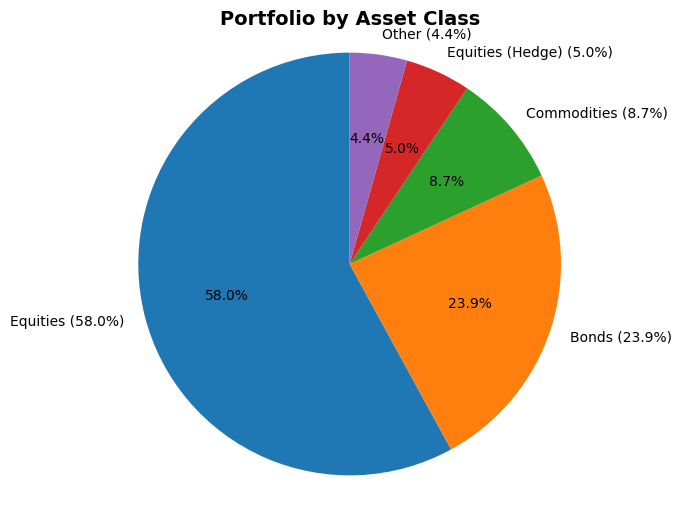


Weighted average correlation: 0.12
Diversification ratio: 2.78
Class-level correlation matrix:
                  Equities  Bonds  Commodities  Equities (Hedge)  Other
Equities              1.00  -0.15         0.05             -0.95  -0.69
Bonds                -0.15   1.00         0.29              0.16   0.23
Commodities           0.05   0.29         1.00             -0.06  -0.01
Equities (Hedge)     -0.95   0.16        -0.06              1.00   0.74
Other                -0.69   0.23        -0.01              0.74   1.00

Top risk contributors (% of variance):
Ticker
NVDA    34.9%
TSLA    26.1%
AAPL    19.5%
MSFT    18.7%
GOOG    12.6%
AMZN    10.6%
SPY     10.0%
GLD      2.9%
SMH      2.0%
IEF      0.5%
Name: risk_contrib, dtype: object

Turnover vs last run: 0.00% | est. one-shot cost: 0.00%


/tmp/ipython-input-960823686.py:74: FutureWarning: YF.download() has changed argument auto_adjust default to True
  latest = yf.download(list(w_series.index), period="5d", progress=False)["Close"].ffill().iloc[-1]



Order blotter preview:
         price  target_w  target_qty  current_qty  order_qty
Ticker                                                      
AAPL    230.49  0.099997          43            0         43
AMZN    229.12  0.050480          22            0         22
DGP     104.99  0.005163           4            0          4
EEM      49.91 -0.000000          -1            0         -1
EFA      91.68 -0.000000          -1            0         -1
EWJ      78.63 -0.000000          -1            0         -1
EWZ      29.02 -0.000000          -1            0         -1
FXI      38.22 -0.000000          -1            0         -1
GLD     312.71  0.082207          26            0         26
GOOG    208.21  0.068452          32            0         32
IEF      96.01  0.100004         104            0        104
IWM     235.94 -0.000000          -1            0         -1

=== Portfolio vs Benchmark ===
Metric                   Portfolio       Benchmark
Annualized return              13.71%  

/tmp/ipython-input-1484871409.py:1281: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rdates = rets.resample(freq).last().index



=== Walk-forward (out-of-sample) stats ===
ann_return            : 6.21%
ann_vol               : 9.80%
sharpe                : 0.4613
mdd                   : -27.08%
var1d_95              : 1.00%
cvar1d_95             : 1.51%
var21d_95             : 4.29%
cvar21d_95            : 5.70%


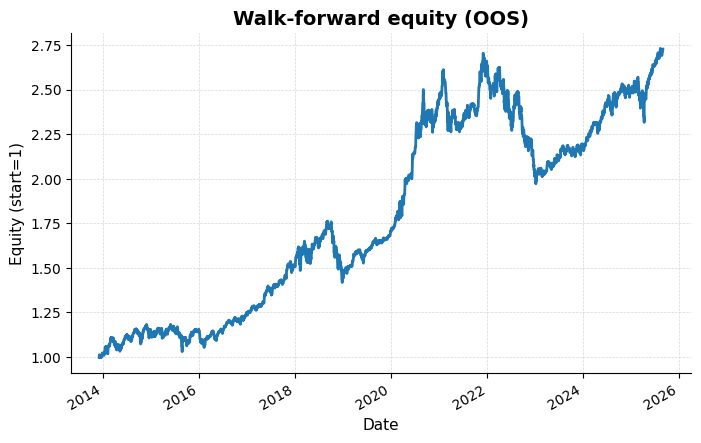


Running Monte Carlo...
MC expected 1y return: 11.60% | median: 11.28% | p5: -2.03% | p95: 26.46%

=== Simple 1-day stress tests ===
         Scenario Portfolio 1-day P&L (%)
Equities -20% day                  -11.59
    Gold -10% day                   -0.87
  Crypto -30% day                    0.00
Saved:
 - outputs/summary.csv
 - outputs/mc_stats.json
 - outputs/mc_final_returns.csv
 - outputs/weights.csv


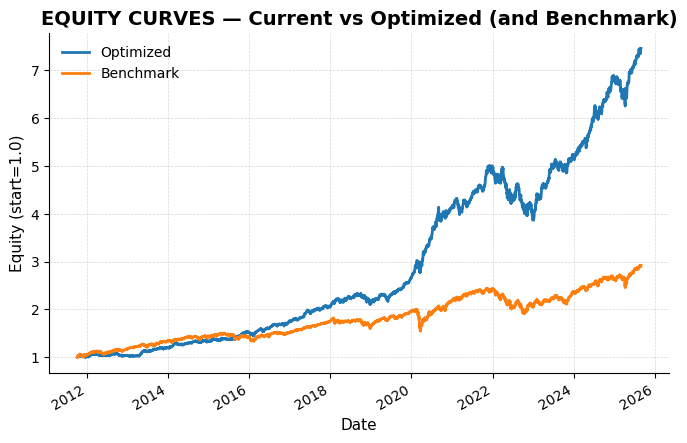


Config saved to outputs/config.json


In [46]:
def main(cfg: Dict):
    start, end = cfg["start"], cfg["end"]

    # 1) Universe
    prices = download_and_filter_universe(cfg)
    rf_annual = cfg["risk_free_annual"]
    mc_paths, mc_days = cfg["mc_paths"], cfg["mc_days"]
    out_dir = cfg["save_folder"]
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    make_plots = bool(cfg.get("make_charts", True))
    show_plots  = bool(cfg.get("show_plots", True))

    print("Got price history shape:", prices.shape)

    # 2) Returns matrix for optimizer/stats
    rets_df = prices.pct_change().dropna()

    # 3) Optimize (or fallback to equal-weight if optimizer disabled)
    bench_series = None
    if cfg.get("benchmark_ticker"):
        bpx = download_benchmark(cfg["benchmark_ticker"], start, end)
        bench_series = bpx.pct_change().reindex(rets_df.index)

    if cfg.get("run_optimizer", False):
        opt_cfg  = cfg.get("optimizer", {})
        w_series = optimize_portfolio(rets_df[prices.columns], rf_annual, bench_series, opt_cfg)
        w_series.to_csv(f"{out_dir}/optimized_weights.csv", header=True)
        print(f"Saved optimized weights → {out_dir}/optimized_weights.csv")
    else:
        eq_w = np.repeat(1.0/len(prices.columns), len(prices.columns))
        w_series = pd.Series(eq_w, index=prices.columns, name="weight")

    # 4) Compute portfolio stats using optimized weights
    print("Computing portfolio stats...")
    res = compute_portfolio_stats(prices[w_series.index], w_series.values, rf_annual)

    # 5) Optional: optimized summary, pie
    pr_opt = summarize_portfolio_from_weights(rets_df[w_series.index], w_series, bench_series, rf_annual)
    plot_asset_class_pie(w_series, out_path=f"{out_dir}/asset_class_pie.png")

    # 6) Correlation & diversification summary (after optimizer)
    avg_corr = portfolio_avg_correlation(rets_df[w_series.index], w_series)
    div_ratio = diversification_ratio(rets_df[w_series.index], w_series)
    cls_corr  = class_level_corr(rets_df[w_series.index], w_series)
    print(f"\nWeighted average correlation: {avg_corr:.2f}")
    print(f"Diversification ratio: {div_ratio:.2f}")
    if not cls_corr.empty:
        print("Class-level correlation matrix:")
        print(cls_corr.round(2).to_string())
        cls_corr.to_csv(f"{out_dir}/class_level_correlation.csv")
    else:
        print("Class-level correlation matrix: not enough non-zero class weights to compute.")

    # 7) Risk contributions, vol targeting, turnover, liquidity, orders
    rc = risk_contributions(rets_df, w_series).sort_values(ascending=False)
    print("\nTop risk contributors (% of variance):")
    print((rc.head(10)*100).round(1).astype(str) + "%")
    rc.to_csv(f"{out_dir}/risk_contributions.csv")

    w_vol = volatility_target_weights(rets_df, w_series, target_ann_vol=0.10)
    w_vol.to_csv(f"{out_dir}/weights_vol_targeted.csv", header=True)

    to, cost = turnover_and_costs(w_series, tc_bps=CONFIG["optimizer"]["tc_bps"])
    if to is not None:
        print(f"\nTurnover vs last run: {to:.2%} | est. one-shot cost: {cost:.2%}")

    AUM = 100_000.0
    breaches = liquidity_check(w_series.index, CONFIG["start"], CONFIG["end"], w_series, AUM)
    if not breaches.empty:
        print("\n⚠️ Liquidity breaches (position as % of ADV):")
        print((breaches*100).round(1).astype(str) + "%")

    latest = yf.download(list(w_series.index), period="5d", progress=False)["Close"].ffill().iloc[-1]
    orders = target_to_orders(latest, w_series, equity_value=100_000)
    orders.to_csv(f"{out_dir}/orders.csv")
    print("\nOrder blotter preview:")
    print(orders.head(12).to_string())

    # 8) Benchmark comparison
    bench_ticker = cfg.get("benchmark_ticker")
    bench_rets = None
    bench_rets_full = None
    if bench_ticker:
        bench_px = download_benchmark(bench_ticker, start, end)
        bench_rets = bench_px.pct_change().reindex(res.rets.index)
        aligned = pd.concat([res.rets, bench_rets], axis=1).dropna()
        aligned.columns = ["port", "bench"]
        port_rets_aligned = aligned["port"]; bench_rets = aligned["bench"]

        bench_rets_full = bench_px.pct_change().reindex(res.rets.index)
        bench_stats = compute_basic_stats_from_series(bench_rets, rf_annual)
        port_stats_again = compute_basic_stats_from_series(port_rets_aligned, rf_annual)
        rel = compute_relative_metrics(port_rets_aligned, bench_rets, rf_annual)
        print_port_vs_bench_table(port_stats_again, bench_stats, rel)
    else:
        print("\nNo benchmark_ticker set in CONFIG; skipping benchmark comparison.")

    # 9) Crisis scorecard
    eq_full = (1 + res.rets).cumprod()
    analyze_crises(
        port_rets=res.rets,
        equity_full=eq_full,
        windows=cfg.get("crisis_windows", []),
        out_dir=out_dir,
        bench_rets_full=bench_rets_full
    )

    # ----- Walk-forward OOS backtest (optional)
    if "walk_forward" in cfg:
        print("\nRunning walk-forward backtest...")
        bench_for_wf = None
        if cfg.get("benchmark_ticker"):
            bpx = download_benchmark(cfg["benchmark_ticker"], cfg["start"], cfg["end"])
            bench_for_wf = bpx.pct_change()

        wf_rets = walk_forward_backtest(prices, cfg, bench_for_wf)
        if not wf_rets.empty:
            wf_stats = compute_basic_stats_from_series(wf_rets, cfg["risk_free_annual"])
            print("\n=== Walk-forward (out-of-sample) stats ===")
            for k,v in wf_stats.items():
                print(f"{k:22}: {v:.4f}" if "sharpe" in k.lower() else f"{k:22}: {v:.2%}")
            # Save & plot
            pd.DataFrame({"wf_rets": wf_rets}).to_csv(f"{out_dir}/walk_forward_returns.csv")
            if make_plots and HAS_MPL:
                set_mpl_style()
                ((1+wf_rets).cumprod()).plot(lw=2)
                plt.title("Walk-forward equity (OOS)")
                plt.xlabel("Date"); plt.ylabel("Equity (start=1)")
                plt.savefig(f"{out_dir}/walk_forward_equity.png")
                if show_plots: plt.show()

    # 10) Monte Carlo & stress tests (use same weights)
    print("\nRunning Monte Carlo...")
    equity_curves, final_returns, stats = monte_carlo(res.mu_daily, res.cov_daily, w_series.values, mc_paths, mc_days)
    print("MC expected 1y return: {:.2%} | median: {:.2%} | p5: {:.2%} | p95: {:.2%}".format(
        stats["expected_1y_return_mc"], stats["median_1y_return_mc"], stats["p5_1y_return_mc"], stats["p95_1y_return_mc"]
    ))

    print("\n=== Simple 1-day stress tests ===")
    st = stress_tests(prices[w_series.index], w_series.values)
    print(st.to_string(index=False, formatters={"Portfolio 1-day P&L (%)": "{:.2f}".format}))

    # 11) Save & charts
    save_outputs(res, stats, final_returns, out_dir)
    if make_plots:
        set_mpl_style()
        plt.figure()
        (1 + pr_opt).cumprod().plot(label="Optimized", linewidth=2)
        if bench_series is not None:
            (1 + bench_series.fillna(0)).cumprod().plot(label="Benchmark", linewidth=2)
        plt.title("EQUITY CURVES — Current vs Optimized (and Benchmark)")
        plt.xlabel("Date"); plt.ylabel("Equity (start=1.0)")
        plt.legend()
        plt.savefig(f"{out_dir}/optimized_equity.png")
        if show_plots: plt.show()

    with open(f"{out_dir}/config.json", "w") as f:
        json.dump(cfg, f, indent=2)
    print(f"\nConfig saved to {out_dir}/config.json")

if __name__ == "__main__":
    cfg = CONFIG.copy()
if len(sys.argv) > 1 and sys.argv[1].endswith(".json"):
        with open(sys.argv[1], "r") as f:
            user_cfg = json.load(f)
        cfg.update(user_cfg)
main(cfg)